In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import itertools
import time
from tqdm import tqdm
import sympy as sp
x = sp.var('x')
from sympy import Symbol
from sympy.solvers import solve
import math
import matplotlib.pyplot as plt
import collections

import warnings
warnings.filterwarnings("ignore")

# Import our adaptive module:
from adaptive_MDP import Adaptive
from adaptive_MDP import Adaptive_New
from non_adaptive import NonAdaptive
import poly_utils

### Examples to initialize

In [90]:
# # ================================================== #

# # Initial parameters (Example from Fenichel et al):
# mu = 0
# gamma = 0.1823
# beta = 0.0825
# phi = 0

# # R values:
# Rmu = mu/(mu+ gamma)
# Rphi = phi/(mu + gamma)

# ### Adaptive parameters

# # Quadratic Utility functions:

# b_s = 10 # Making the max utility attained at b_s/2 
# b_i = 6.67 # Making the max utility attained at b_i/2 
# b_z = 10 # Making the max utility attained at b_z/2 
# a_s = 0
# a_i = 1.826
# a_z = 0
# nu = 0.25
# tau = 12
# delta = 0.99986

# # ================================================== #

# # Immediate rewards: (Utility functions)
# def u_s(a):
#     return (b_s*a - a**2)**nu - a_s
# def u_i(a):
#     return (b_i*a - a**2)**nu - a_i
# def u_z(a):
#     return (b_z*a - a**2)**nu - a_z

# ### Simulation parameters
# t_max = 150
# steps = 100
# x00 = [9999, 1, 0]

In [91]:
# # ================================================== #

# # Initial parameters (Example from B. Morin et al): Not working for now (?)
# Lambda = 80
# mu = Lambda/10000 # (making mu*N = Lambda)
# gamma = 0.2
# beta = 0.2
# phi = 0

# # R values:
# Rmu = mu/(mu+ gamma)
# Rphi = phi/(mu + gamma)

# ### Adaptive parameters

# # Quadratic Utility functions:

# b_s = 24 # Making the max utility attained at b_s/2 
# b_i = 12 # Making the max utility attained at b_i/2 
# b_z = 24 # Making the max utility attained at b_z/2 
# nu = 0.2
# tau = 3
# delta = 0.9986

# # ================================================== #

# # Immediate rewards: (Utility functions)
# def u_s(a):
#     return (b_s*a - a**2)**nu
# def u_i(a):
#     return 0
# def u_z(a):
#     return (b_z*a - a**2)**nu

# ### Simulation parameters
# t_max = 900
# steps = 100
# x00 = [9999, 1, 0]

In [112]:
# Initial parameters Our example with relapse (from chapter 2)----- #
mu = 0.00015
gamma = 0.0027
beta = 0.00096
phi = 0.0044

# R values:
Rmu = mu/(mu+ gamma)
Rphi = phi/(mu + gamma)

### Adaptive parameters

# Quadratic Utility functions:

b_s = 24 # Making the max utility attained at b_s/2 
b_i = 20 # Making the max utility attained at b_i/2 
b_z = 30 # Making the max utility attained at b_z/2 
a_s = 0
a_i = 0
a_z = 0
nu = 0.01375
tau = 12
delta = 0.9986

# Immediate rewards:
def u_s(a):
    return (b_s*a - a**2)**nu - a_s
def u_i(a):
    return (b_i*a - a**2)**nu - a_i
def u_z(a):
    return (b_z*a - a**2)**nu - a_z

### Simulation parameters
t_max = 5000
steps = 100
x00 = [9999, 1, 0]

### Paste uni-step solutions through time

In [113]:
# Initialize adaptive instances
instance_adaptive = Adaptive_New(
    mu, gamma, beta, phi,
    tau, delta,
    u_s, u_i, u_z,
    t_max, steps, x00, max_contacts=30,
    logs=True, verbose=False)
start = time.time()
instance_adaptive.patch_uni_solutions()
end = time.time()
print(f"Running the adaptive algorithm took {(end - start)/60} minutes.")

Patching unit time solutions ...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:52<00:00,  7.01it/s]

Running the adaptive algorithm took 11.88138165473938 minutes.


### Display history of optimal contacts selected

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 374.73it/s]


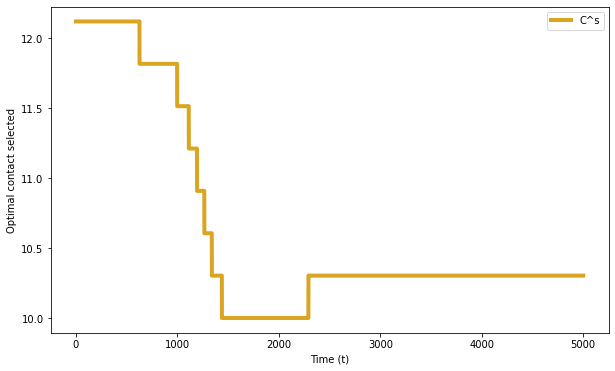

In [114]:
Cs = instance_adaptive.cs_history
cs_unistep = []
for i in tqdm(range(len(Cs))):
    cs_unistep = cs_unistep + [Cs[i]]*instance_adaptive.steps

plt.plot(np.linspace(0, instance_adaptive.t_max, len(cs_unistep)), cs_unistep, 'goldenrod', label="C^s", linewidth=4, )
plt.xlabel("Time (t)")
plt.ylabel("Optimal contact selected")
plt.legend(loc = "upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 367.77it/s]


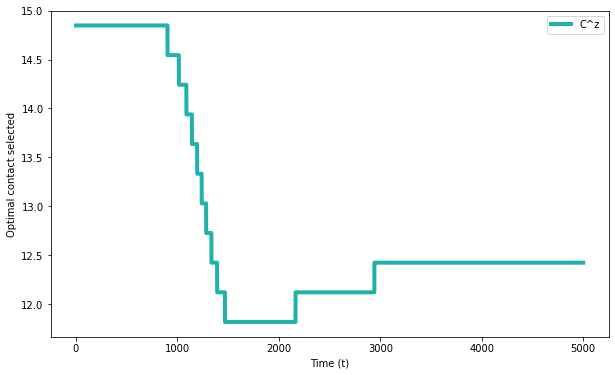

In [115]:
Cs = instance_adaptive.cz_history
cs_unistep = []
for i in tqdm(range(len(Cs))):
    cs_unistep = cs_unistep + [Cs[i]]*instance_adaptive.steps

plt.plot(np.linspace(0, instance_adaptive.t_max, len(cs_unistep)), cs_unistep, 'lightseagreen', label="C^z", linewidth=4, )
plt.xlabel("Time (t)")
plt.ylabel("Optimal contact selected")
plt.legend(loc = "upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 367.34it/s]


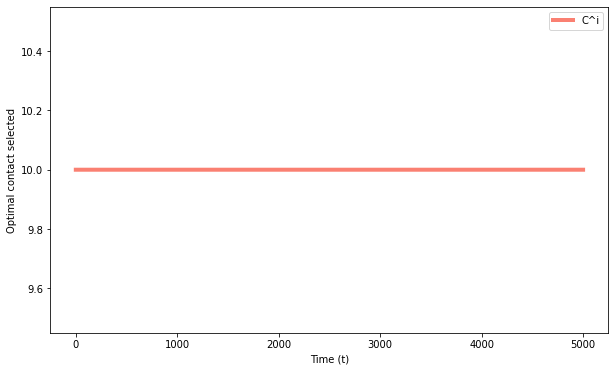

In [116]:
Cs = instance_adaptive.ci_history
cs_unistep = []
for i in tqdm(range(len(Cs))):
    cs_unistep = cs_unistep + [Cs[i]]*instance_adaptive.steps

plt.plot(np.linspace(0, instance_adaptive.t_max, len(cs_unistep)), cs_unistep, 'salmon', label="C^i", linewidth=4, )
plt.xlabel("Time (t)")
plt.ylabel("Optimal contact selected")
plt.legend(loc = "upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

### Plot solution of the system through time

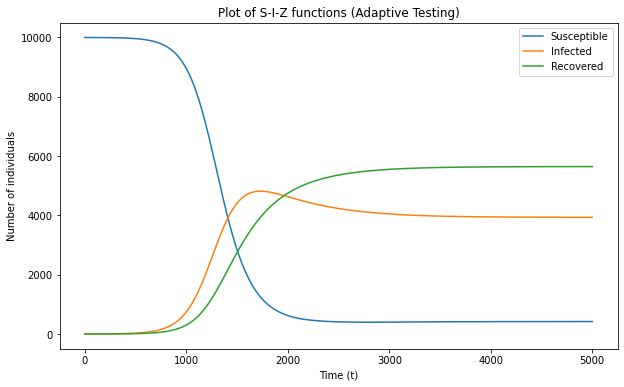

In [117]:
t = np.linspace(0, instance_adaptive.t_max, len(instance_adaptive.S))
instance_adaptive.plot_ode_solution(t = t, title = 'Adaptive Testing')

### Comparison with NON Adaptive models

In [118]:
start = time.time()
# To compare, we take the Cs obtained at the start (ex ante) and at the end (ex post)

instance_non_adaptive_ex_ante = NonAdaptive(
    mu, gamma, beta, phi,
    instance_adaptive.cs_history[0],
    instance_adaptive.ci_history[0],
    instance_adaptive.cz_history[0], x00, t_max)

instance_non_adaptive_ex_post = NonAdaptive(
    mu, gamma, beta, phi,
    instance_adaptive.cs_history[-1],
    instance_adaptive.ci_history[-1],
    instance_adaptive.cz_history[-1], x00, t_max)

instance_non_adaptive_ex_ante.solve_odes_system()
instance_non_adaptive_ex_post.solve_odes_system()

end = time.time()
print(f"Running the NON adaptive algorithms took {end - start} seconds.")

100%|███████████████████████████████████████████████████████████████████████| 500001/500001 [00:38<00:00, 13110.52it/s]


Running the NON adaptive algorithms took 76.87414360046387 seconds.




Proportions and contacts.

Ex ante:
    - Cs: 12.121212121212121
    - Ci: 10.0
    - Cz: 14.84848484848485
    - kappa: 0.825
    - theta: 1.225
    
Ex post:
    - Cs: 10.303030303030303
    - Ci: 10.0
    - Cz: 12.424242424242424
    - kappa: 0.9705882352941176
    - theta: 1.2058823529411764

---- Final Points Attained ------------

Ex ante:  0.39510210279257163
Ex post:  0.3934389345748676
Adaptive: 0.39348023238418495

Theoretical Convergence Points:

Ex ante: []
Ex post: []

R0 Non Adaptive:

Ex ante: 0.3368421052631579
Ex post: 0.3368421052631579


Epidemic Maximum:

Ex ante:  4936.871974499804
Ex post:  4815.537279707531
Adaptive: 4815.539074485804

Time Epidemic Maximum is achieved:

Ex ante:  1699.16
Ex post:  1737.94
Adaptive: 1747.42

------------------------------



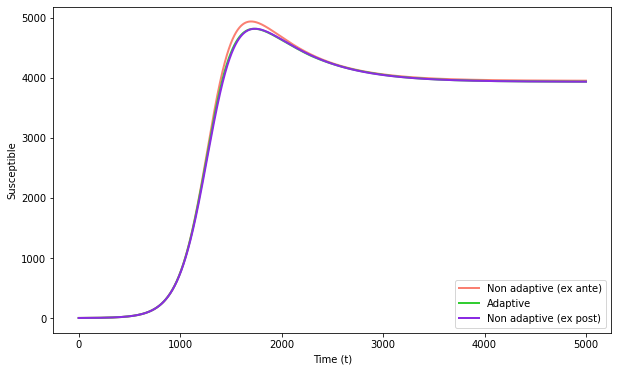

In [119]:
R0_ante = instance_non_adaptive_ex_ante.I[0]*beta/(gamma + mu)
R0_post = instance_non_adaptive_ex_post.I[0]*beta/(gamma + mu)

kappa_ante = instance_adaptive.ci_history[0]/instance_adaptive.cs_history[0]
theta_ante = instance_adaptive.cz_history[0]/instance_adaptive.cs_history[0]

kappa_post = instance_adaptive.ci_history[-1]/instance_adaptive.cs_history[-1]
theta_post = instance_adaptive.cz_history[-1]/instance_adaptive.cs_history[-1]

print(f"""

Proportions and contacts.

Ex ante:
    - Cs: {instance_adaptive.cs_history[0]}
    - Ci: {instance_adaptive.ci_history[0]}
    - Cz: {instance_adaptive.cz_history[0]}
    - kappa: {kappa_ante}
    - theta: {theta_ante}
    
Ex post:
    - Cs: {instance_adaptive.cs_history[-1]}
    - Ci: {instance_adaptive.ci_history[-1]}
    - Cz: {instance_adaptive.cz_history[-1]}
    - kappa: {kappa_post}
    - theta: {theta_post}

---- Final Points Attained ------------

Ex ante:  {instance_non_adaptive_ex_ante.I[-1]/sum(x00)}
Ex post:  {instance_non_adaptive_ex_post.I[-1]/sum(x00)}
Adaptive: {instance_adaptive.I[-1]/sum(x00)}

Theoretical Convergence Points:

Ex ante: {poly_utils.solve_polynomial(Rphi, Rmu, R0_ante, kappa_ante, theta_ante)}
Ex post: {poly_utils.solve_polynomial(Rphi, Rmu, R0_post, kappa_post, theta_post)}

R0 Non Adaptive:

Ex ante: {R0_ante}
Ex post: {R0_post}


Epidemic Maximum:

Ex ante:  {np.max(instance_non_adaptive_ex_ante.I)}
Ex post:  {np.max(instance_non_adaptive_ex_post.I)}
Adaptive: {np.max(instance_adaptive.I)}

Time Epidemic Maximum is achieved:

Ex ante:  {instance_non_adaptive_ex_ante.I.tolist().index(np.max(instance_non_adaptive_ex_ante.I))/steps}
Ex post:  {instance_non_adaptive_ex_post.I.tolist().index(np.max(instance_non_adaptive_ex_post.I))/steps}
Adaptive: {instance_adaptive.I.tolist().index(np.max(instance_adaptive.I))/steps}

------------------------------
""")

plt.plot(
    np.linspace(0,t_max,len(instance_non_adaptive_ex_ante.I)),
    instance_non_adaptive_ex_ante.I, "salmon", label="Non adaptive (ex ante)", linewidth=2)
plt.plot(
    np.linspace(0,t_max,len(instance_adaptive.I)),
    instance_adaptive.I, "limegreen", label="Adaptive", linewidth=2)
plt.plot(
    np.linspace(0,t_max,len(instance_non_adaptive_ex_post.I)),
    instance_non_adaptive_ex_post.I, "blueviolet", label="Non adaptive (ex post)", linewidth=2)

# plt.axvline(x = 2400, color = 'b')

plt.xlabel("Time (t)")
plt.ylabel("Susceptible")
plt.legend(loc = "lower right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

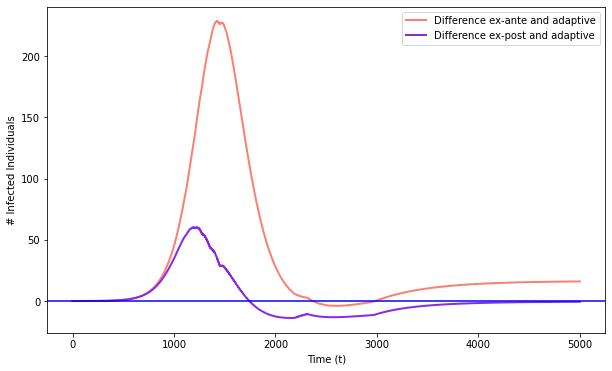

In [120]:
diff_ante_adaptive = [instance_non_adaptive_ex_ante.I[i] - instance_adaptive.I[i] for i in range(len(instance_non_adaptive_ex_ante.I))]
diff_post_adaptive = [instance_non_adaptive_ex_post.I[i] - instance_adaptive.I[i] for i in range(len(instance_non_adaptive_ex_post.I))]

plt.plot(
    np.linspace(0,t_max,len(instance_non_adaptive_ex_ante.I)),
    diff_ante_adaptive, "salmon", label="Difference ex-ante and adaptive", linewidth=2)
plt.plot(
    np.linspace(0,t_max,len(instance_non_adaptive_ex_ante.I)),
    diff_post_adaptive, "blueviolet", label="Difference ex-post and adaptive", linewidth=2)

plt.axhline(y = 0, color = 'b')

plt.xlabel("Time (t)")
plt.ylabel("# Infected Individuals")
plt.legend(loc = "upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

### Other Comparisons

*Infection parameter matters*

Note that $\beta$ is present at the formulation of the transition probability: $P_{si}(a) = 1 - \exp\left(\frac{-\beta\cdot a \cdot C_i^*I}{S(t)\cdot C_s^* +I(t)\cdot C_i^* + Z(t)\cdot C_z^*}\right)$, making this probability close to zero if $\beta$ is small.

Reducing $\beta$ thus reduces the posibility of altering the selection of contact rates at the adaptive algorithm. Here's the same example from above, with a smaller $\beta$, we can see that the adaptive behavior is less variable (meaning that it deviates less from the optimal point of the utility function).

In [102]:
effect_of_beta = pd.read_csv(r"C:\Users\jimmy\OneDrive\Desktop\Maestria Metodos Matematicos y Aplicaciones\Tesis\adaptive\design\adaptive\data\effect_of_beta_1.csv")

In [103]:
effect_of_beta.head(4)

,Unnamed: 0,beta,min_cs,peak_i
0,0,0.050000,5.0,1.0
1,1,0.050505,5.0,1.0
2,2,0.051010,5.0,1.0
3,3,0.051515,5.0,1.0


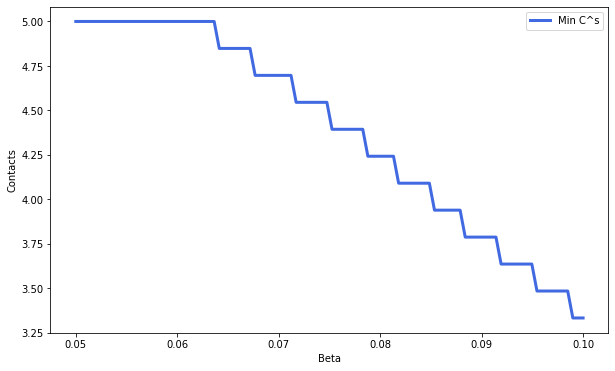

In [111]:
plt.plot(effect_of_beta['beta'],
         effect_of_beta['min_cs'], "royalblue", label="Min C^s", linewidth=3)
plt.xlabel("Beta")
plt.ylabel("Contacts")
plt.legend(loc = "upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

In [95]:
effect_of_tau1 = pd.read_csv(r"C:\Users\jimmy\OneDrive\Desktop\Maestria Metodos Matematicos y Aplicaciones\Tesis\adaptive\design\adaptive\data\effect_of_tau_1.csv")

In [96]:
effect_of_tau1.head(2)

,Unnamed: 0,tau,min_cs,peak_i
0,0,2,4.393939,983.684100
1,1,4,4.090909,937.640917


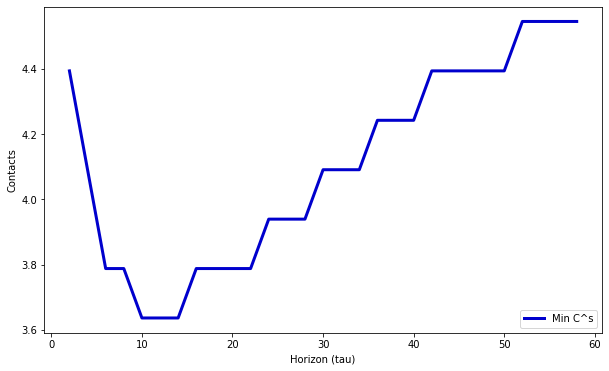

In [107]:
plt.plot(effect_of_tau1['tau'],
         effect_of_tau1['min_cs'], "mediumblue", label="Min C^s", linewidth=3)
plt.xlabel("Horizon (tau)")
plt.ylabel("Contacts")
plt.legend(loc = "lower right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

Changing $a_i=0$ in the non relapse model modifies the behavior of the previous plot.

In [109]:
effect_of_tau2 = pd.read_csv(r"C:\Users\jimmy\OneDrive\Desktop\Maestria Metodos Matematicos y Aplicaciones\Tesis\adaptive\design\adaptive\data\effect_of_tau_2.csv")

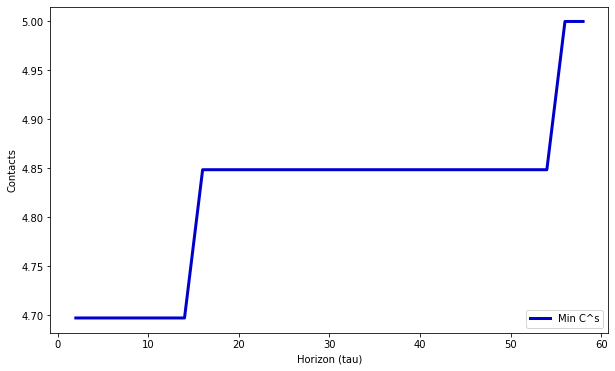

In [110]:
plt.plot(effect_of_tau2['tau'],
         effect_of_tau2['min_cs'], "mediumblue", label="Min C^s", linewidth=3)
plt.xlabel("Horizon (tau)")
plt.ylabel("Contacts")
plt.legend(loc = "lower right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()